In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import os
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from IPython.display import Image
from keras import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras import datasets, layers, models, losses
# from google.colab import drive
# drive.mount('/content/drive')


In [4]:
%%capture
import zipfile
!unzip /content/CIFAKE.zip

In [5]:
dataset_dir = os.path.join(os.getcwd(), "CIFAKE")

img_height = 32
img_width = 32
batch_size = 256

# Load training and validation data
train, val = keras.utils.image_dataset_from_directory(
  os.path.join("train"),
  validation_split=0.2,
  subset="both",
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Using 20000 files for validation.


In [6]:
test = keras.utils.image_dataset_from_directory(
  os.path.join("test"),
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 20000 files belonging to 2 classes.


In [7]:
classes = train.class_names
classes

['FAKE', 'REAL']

In [8]:
input = layers.Input(shape=(32,32,3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=(32,32,3))(input)
# 7x7 convolution with stride 2 and 64 filters
x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_tensor)
# 3x3 max pooling with stride 2
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
# 1x1 convolution with 64 filters
x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
# 3x3 convolution with 192 filters
x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
# 3x3 max pooling with stride 2
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
#inception 1
branch1 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(96, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(16, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(32, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#inception 2
branch1 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(96, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
#inception 3
branch1 = layers.Conv2D(192, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(96, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(208, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(16, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(48, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#auxiliary 1
auxx = layers.AveragePooling2D((5, 5), strides=(3, 3))(x)
auxx = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(auxx)
auxx = layers.Flatten()(auxx)
auxx = layers.Dense(1024, activation='relu')(auxx)
auxx = layers.Dropout(0.7)(auxx)
auxx = layers.Dense(1, activation='sigmoid', name="aux1")(auxx)
#inception 4
branch1 = layers.Conv2D(160, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(112, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(224, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(24, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#inception 5
branch1 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(24, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#inception 6
branch1 = layers.Conv2D(112, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(144, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(288, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#auxiliary 2
auxx2 = layers.AveragePooling2D((5, 5), strides=(3, 3))(x)
auxx2 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(auxx2)
auxx2 = layers.Flatten()(auxx2)
auxx2 = layers.Dense(1024, activation='relu')(auxx2)
auxx2 = layers.Dropout(0.7)(auxx2)
auxx2 = layers.Dense(1, activation='sigmoid', name="aux2")(auxx2)
#inception 7
branch1 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(160, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(320, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(128, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
#inception 8
branch1 = layers.Conv2D(256, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(160, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(320, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(128, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)
#inception 9
branch1 = layers.Conv2D(384, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(192, (1, 1), padding='same', activation='relu')(x)
branch2 = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(branch2)
branch3 = layers.Conv2D(48, (1, 1), padding='same', activation='relu')(x)
branch3 = layers.Conv2D(128, (5, 5), padding='same', activation='relu')(branch3)
branch4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
branch4 = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(branch4)
x = layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)

x = layers.AveragePooling2D((7, 7), strides=(1, 1))(x)
x = layers.Dropout(0.4)(x)
x = layers.Flatten()(x)

output = layers.Dense(1, activation='sigmoid', name='output')(x)

model = keras.Model(input, [output, auxx, auxx2], name='inceptionnet')

In [9]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=[losses.binary_crossentropy, losses.binary_crossentropy, losses.binary_crossentropy],
              loss_weights=[1, 0.3, 0.3],
              metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")])

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_output_accuracy', mode='max', patience=10,  restore_best_weights=True, verbose=1)
model.summary()

Model: "inceptionnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 resizing (Resizing)         (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['resizing[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d[0][0]']              
 D)                                                                                    

In [10]:
epochs = 80

history = model.fit(
  train,
  validation_data=val,
  epochs=epochs,
  verbose=0, callbacks=[es])

history = pd.DataFrame(history.history)
display(history)

Restoring model weights from the end of the best epoch: 43.
Epoch 53: early stopping


,loss,output_loss,aux1_loss,aux2_loss,output_accuracy,output_precision,output_recall,aux1_accuracy,aux1_precision,aux1_recall,...,val_aux2_loss,val_output_accuracy,val_output_precision,val_output_recall,val_aux1_accuracy,val_aux1_precision,val_aux1_recall,val_aux2_accuracy,val_aux2_precision,val_aux2_recall
0,0.640333,0.389390,0.438575,0.397901,0.813137,0.808219,0.820933,0.806500,0.799873,0.817357,...,0.302812,0.88485,0.843672,0.945182,0.85515,0.791721,0.964453,0.86600,0.809415,0.957963
1,0.387674,0.235826,0.263726,0.242432,0.902200,0.900281,0.904514,0.891250,0.885502,0.898612,...,0.209837,0.90755,0.862611,0.969845,0.91555,0.902611,0.931902,0.91500,0.880828,0.960160
2,0.320891,0.194827,0.220804,0.199411,0.921550,0.919652,0.923746,0.910837,0.907492,0.914868,...,0.183988,0.92475,0.937667,0.910235,0.91945,0.902413,0.940889,0.92605,0.929982,0.921717
3,0.283818,0.171944,0.197250,0.175662,0.931162,0.928852,0.933800,0.921962,0.918552,0.925972,...,0.154922,0.94090,0.939847,0.942287,0.93280,0.947651,0.916425,0.94050,0.945212,0.935397
4,0.249108,0.150120,0.175979,0.153980,0.940600,0.938778,0.942629,0.929862,0.927665,0.932375,...,0.187021,0.92305,0.886397,0.970744,0.91425,0.869612,0.974938,0.92950,0.898638,0.968447
5,0.231409,0.138716,0.164539,0.144438,0.945238,0.944828,0.945655,0.934537,0.933008,0.936251,...,0.146797,0.94360,0.970162,0.915527,0.93650,0.967497,0.903545,0.94525,0.967407,0.921717
6,0.207064,0.123063,0.150535,0.129469,0.952213,0.951438,0.953032,0.941625,0.940523,0.942829,...,0.138611,0.94920,0.963150,0.934299,0.94460,0.949985,0.938792,0.94760,0.969526,0.924413
7,0.200210,0.118591,0.147802,0.124263,0.954525,0.953397,0.955733,0.942225,0.941320,0.943204,...,0.130207,0.95080,0.961377,0.939491,0.94260,0.965949,0.917723,0.95055,0.962492,0.937793
8,0.183388,0.107652,0.137595,0.114856,0.958363,0.957010,0.959810,0.946250,0.945494,0.947055,...,0.131076,0.95380,0.955781,0.951772,0.94755,0.944301,0.951373,0.95045,0.962200,0.937893
9,0.166570,0.095990,0.130463,0.104802,0.963162,0.963091,0.963211,0.949600,0.948997,0.950231,...,0.127415,0.95205,0.934132,0.972841,0.94740,0.932870,0.964353,0.95145,0.932066,0.974039


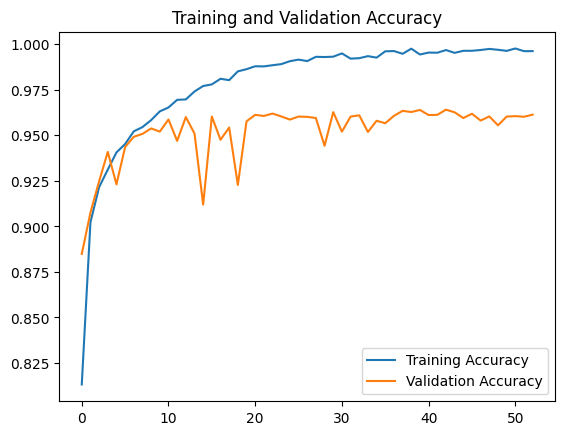

In [11]:
plt.plot(range(len(history)), history["output_accuracy"], label="Training Accuracy")
plt.plot(range(len(history)), history["val_output_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

In [12]:
model.evaluate(test, return_dict=True)

79/79 [==============================] - 6s 71ms/step - loss: 0.2833 - output_loss: 0.1850 - aux1_loss: 0.1573 - aux2_loss: 0.1703 - output_accuracy: 0.9646 - output_precision: 0.9683 - output_recall: 0.9606 - aux1_accuracy: 0.9577 - aux1_precision: 0.9739 - aux1_recall: 0.9405 - aux2_accuracy: 0.9622 - aux2_precision: 0.9709 - aux2_recall: 0.9531


{'loss': 0.2832557260990143,
 'output_loss': 0.1849530041217804,
 'aux1_loss': 0.15733039379119873,
 'aux2_loss': 0.1703455150127411,
 'output_accuracy': 0.9646000266075134,
 'output_precision': 0.9683467745780945,
 'output_recall': 0.9606000185012817,
 'aux1_accuracy': 0.9576500058174133,
 'aux1_precision': 0.9739049673080444,
 'aux1_recall': 0.940500020980835,
 'aux2_accuracy': 0.9622499942779541,
 'aux2_precision': 0.970866858959198,
 'aux2_recall': 0.9531000256538391}

In [13]:
preds = model.predict(test)

79/79 [==============================] - 6s 67ms/step


In [23]:
len(preds[0])

20000

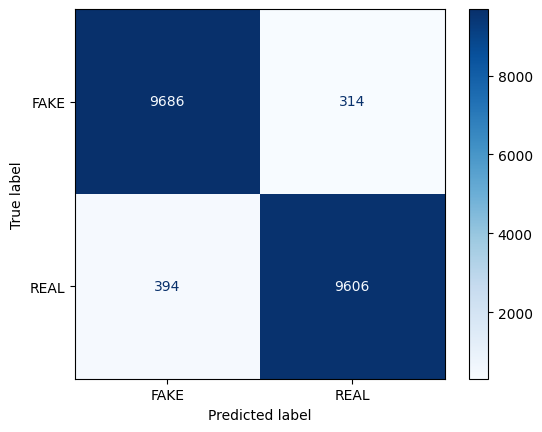

In [22]:
test_predictions = np.array([])
test_labels = np.array([])
for x, y in test:
    test_predictions = np.append(test_predictions, model(x)[0] > 0.5)
    test_labels = np.append(test_labels, y)
ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, display_labels=classes, cmap="Blues");